# Training data-efficient image transformers & distillation through attention

## overview
DeiT (Data-efficient image Transformers) is a specific type of transformer-based architecture developed for image classification tasks. It was introduced in the paper ["Training data-efficient image transformers & distillation through attention"](https://arxiv.org/pdf/2012.12877.pdf).

DeiT aims to address the limitations of traditional convolutional neural networks (CNNs) by leveraging the power of transformers, which have been successful in natural language processing tasks. The key idea behind DeiT is to apply transformer-based architectures to image data in a data-efficient manner.

In this paper,They introduce a teacher-student strategy specific to
transformers. It relies on a distillation token ensuring that the student
learns from the teacher through attention. They show the interest of this
token-based distillation, especially when using a convnet as a teacher. This
leads to report results competitive with convnets for both Imagenet
(where they obtain up to 85.2% accuracy) and when transferring to other
tasks

In a vision transformer, an input image is divided into patches, and each patch is linearly projected into a lower-dimensional representation called embeddings. These embeddings are then fed into a transformer encoder, which consists of multiple layers of self-attention and feed-forward neural networks. The self-attention mechanism allows the model to capture global relationships between patches by attending to relevant information in other patches.
After passing through the transformer encoder, the resulting embeddings are classified using a linear layer or another type of classifier to predict the labels or perform other visual recognition tasks.

# Model

![Deit architecture](https://i.imgur.com/5lmg2Xs.png)

The throughput is measured for images at resolution 224×224.
Model ViT model embedding #heads #layers #params training throughput
dimension resolution (im/sec)
DeiT-Ti N/A 192 3 12 5M 224 2536
DeiT-S N/A 384 6 12 22M 224 940
DeiT-B ViT-B 768 12 12 86M 224 292
Table 2: We compare on ImageNet [42] the performance (top-1 acc., %) of the
student as a function of the teacher model used for distillation.
Teacher Student: DeiT-B
⚗
Models acc. pretrain ↑384
RegNetY-4GF 80.0 82.7 83.6
RegNetY-8GF 81.7 82.7 83.8
RegNetY-12GF 82.4 83.1 84.1
RegNetY-16GF 82.9 83.1 84.2

In [1]:
!pip install lightning torchmetrics
# !pip install pytorch-lightning -q
# install weights and biases
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.5 MB/s eta 0:00:00


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import tqdm

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import lightning.pytorch as pl

from pytorch_lightning.loggers import WandbLogger

from torch.utils.data import random_split, DataLoader

from torchmetrics import Accuracy

import wandb

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## weight and bias login

In [3]:
# use your own api key
os.environ['WANDB_API_KEY']="0ec57bd2a5f70aeb9eebc481b02f75c286bab8fc"
wandb.login(key = os.environ['WANDB_API_KEY'])


wandb: Currently logged in as: gt277966 (blank0). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# model

let's create simple encoder transformer

In [4]:
dropout = 0.1
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, n_embd, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5  # (B, T, C) @ (B, C, T) -> (B, T, T)
        
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, input_embd_dim, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(input_embd_dim,head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(input_embd_dim, input_embd_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
 
"""
In the paper, they add a Feed-Forward Network (FFN) on top of the MSA layer. This FFN is
composed of two linear layers separated by a GeLu activation. The first
linear layer expands the dimension from D to 4D, and the second layer reduces
the dimension from 4D back to D.
"""
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

    
"""
Combining MSA and FFN
"""
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_embd,n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x



## Positional Encoding

Inorder for the model to make
sense of the sentence, it needs to know two things about the each word.
* what does the word mean?
* what is the position of the word in the sentence.

In "attention is all you need paper" author used the following functions to create positional encoding. On odd time steps a cosine function is used and in even time steps a sine function is used.

<img src="https://miro.medium.com/max/524/1*yWGV9ck-0ltfV2wscUeo7Q.png">

<img src="https://miro.medium.com/max/564/1*SgNlyFaHH8ljBbpCupDhSQ.png">


Positinal embedding will generate a matrix of similar to embedding matrix. It will create a matrix of dimension sequence length x embedding dimension. For each token(word) in sequence, we will find the embedding vector and it is added with the correspondng positional vector.

In [5]:
# register buffer in Pytorch ->
# If you have parameters in your model, which should be saved and restored in the state_dict,
# but not trained by the optimizer, you should register them as buffers.

class PositionalEmbedding(nn.Module):
    def __init__(self,max_seq_len,embed_model_dim):
        """
        Args:
            seq_len: length of input sequence
            embed_model_dim: demension of embedding
        """
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_model_dim

        pe = torch.zeros(max_seq_len,self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0,self.embed_dim,2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/self.embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            x: output
        """

        # make embeddings relatively larger
        x = x * math.sqrt(self.embed_dim)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + self.pe[:,:seq_len]
        return x



## Knowledge distillation

![deit_transformer](https://3033184753-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-MM9anUwG1_XXIkWZ5fh%2F-MVUUmPm4vO5KaEUk6nu%2F-MVU_gUjNx4jl9aB_IK8%2Fknowledge_distillation.png?alt=media&token=4f69a659-2aef-435f-b772-6519c8110f46)

### Teacher model
For Teacher model, we are going to use regnet_y_8gf as used in Deit Paper, but we will gone finetune it with cifar10 dataset. For student model, we will gone use transformer model

In [6]:
# finetuning teacher model
from tqdm import tqdm
from torchvision.models import regnet_y_8gf, RegNet_Y_8GF_Weights

# The inference transforms are available at RegNet_Y_8GF_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
import torchvision



torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#data
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,shuffle=True, num_workers=2)
     


teacher_model = torchvision.models.regnet_y_8gf(weights='IMAGENET1K_V1').to(device)

optimizer = torch.optim.Adam(teacher_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

                                           

## model

def train_teacher_model():
    for param in teacher_model.parameters():
        param.requires_grad = False
    num_classes = 10  # Example: 10 classes for classification
    teacher_model.fc = torch.nn.Linear(teacher_model.fc.in_features, num_classes).to(device)

    num_epochs = 32

    teacher_model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = teacher_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
train_teacher_model()


100%|██████████| 170498071/170498071 [00:03<00:00, 48673443.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Downloading: "https://download.pytorch.org/models/regnet_y_8gf-d0d0e4a8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_8gf-d0d0e4a8.pth
100%|██████████| 151M/151M [00:01<00:00, 86.2MB/s]


Epoch [1/32], Loss: 2.4197


Epoch [2/32], Loss: 2.4214


Epoch [3/32], Loss: 2.4197


Epoch [4/32], Loss: 2.4183


Epoch [5/32], Loss: 2.4184


Epoch [6/32], Loss: 2.4203


Epoch [7/32], Loss: 2.4160


Epoch [8/32], Loss: 2.4184


Epoch [9/32], Loss: 2.4181


Epoch [10/32], Loss: 2.4183


Epoch [11/32], Loss: 2.4161


Epoch [12/32], Loss: 2.4208


Epoch [13/32], Loss: 2.4218


Epoch [14/32], Loss: 2.4187


Epoch [15/32], Loss: 2.4212


Epoch [16/32], Loss: 2.4176


Epoch [17/32], Loss: 2.4166


Epoch [18/32], Loss: 2.4203


Epoch [19/32], Loss: 2.4191


Epoch [20/32], Loss: 2.4222


Epoch [21/32], Loss: 2.4210


Epoch [22/32], Loss: 2.4191


Epoch [23/32], Loss: 2.4218


Epoch [24/32], Loss: 2.4167


Epoch [25/32], Loss: 2.4189


Epoch [26/32], Loss: 2.4201


Epoch [27/32], Loss: 2.4215


Epoch [28/32], Loss: 2.4199


Epoch [29/32], Loss: 2.4207


Epoch [30/32], Loss: 2.4221


Epoch [31/32], Loss: 2.4202


Epoch [32/32], Loss: 2.4192


## Finally let's create deit transformer
note:
1. Class token (Cls token) is added at 0 position. It serves as a learnable representation of the entire image and plays a crucial role in enabling the model to perform image-level classification. Cls token is later feed to feedforward network to do classification
2. Distillation token (Cls token) is added at last position. It serves as a learnable representation of the entire image and plays a crucial role in distilling the information from teascher model

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# student model is Deit model
class DeiT(nn.Module):
    def __init__(self, image_size = 32, patch_size = 8, num_classes=10, hidden_dim = 192, num_heads = 8, num_layers=6):
        
        """
        image size : sizeof image
        patch size : patch size
        hidden_dim : embedding size of each patch 
        num_head: number of heads in each attention layer
        num_layers : total number of attention and feed forward layer
        """
        super(DeiT, self).__init__()
        
        self.patch_size = patch_size
        #calculation number of patches
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2  # Assuming RGB images

        #for embedding patches
        self.patch_embedding = nn.Linear(patch_dim, hidden_dim)
        # cls token is used for classification
        self.cls_token = nn.Parameter(torch.randn(hidden_dim)) 
        # distill token
        self.distill_token = nn.Parameter(torch.randn(hidden_dim)) 
        
        # position embedding 
        max_seq_len = num_patches + 49     #(let it be 49)
        
        self.positional_encoding = PositionalEmbedding(max_seq_len, hidden_dim)
    
        self.encoder = nn.Sequential(*[Block(hidden_dim, n_head=num_heads) for _ in range(num_layers)])

        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        b, _, _, _ = x.shape

        x = self.transform_image_to_patch(x, self.patch_size) ## (b, no.of patches ,patch_dim)
        x = self.patch_embedding(x)                          ## (b,no.of patches, embedding_dim)

        # adding cls token
        b, n, d =x.shape 
        x_new = torch.zeros((b, n+2, d), device = DEVICE)              ## (b,no.of patches+2, embedding_dim)
        x_new[:,0,:] = self.cls_token
        x_new[:,1:-1,:] = x 
        x_new[:,-1,:]= self.distill_token
        
        ## Position embedding 
        x_new = self.positional_encoding(x_new)        
        
        x_new = self.encoder(x_new)  # (b, embedding_dim)
        #taking only class token
        clst = x_new[:,0,:]               # taking cls head part
        clst = self.fc(clst)
        
        #taking distill token
        distill = x_new[:,-1,:]
        distill = self.fc(distill)
        return clst , distill

    
    def transform_image_to_patch(self, input_image, patch_size):
        """ transform image to patchs"""
        input_image = input_image.permute(0,2,3,1)
        batch, image_height, image_width, channels = input_image.shape
        
        num_patches_h = image_height // patch_size
        num_patches_w = image_width // patch_size
        
        #zeros of shape(batch, number of patches, patch_height, patch_width, channel)
        patch_array = torch.zeros((batch, num_patches_h * num_patches_w, patch_size, patch_size, channels), device = DEVICE)

        for b in range(batch):
            patch_idx = 0
              
            for i in range(num_patches_h):
                  for j in range(num_patches_w):
                        
                        start_h = i * patch_size
                        start_w = j * patch_size
                        end_h = start_h + patch_size
                        end_w = start_w + patch_size

                        patch =input_image[b, start_h:end_h, start_w:end_w, :]
                        patch_array[b, patch_idx, :, :, :] = patch
                        patch_idx += 1
        
        #return channel*patch_size**2 i.e. embedding size
        return patch_array.reshape(batch, -1, 3 * patch_size ** 2).float()   # (b,no.of patches ,patch_dim)
    


## Data


We are using CIFAR10 dataset 

In [8]:
# traindata and trainloader are already initialized above
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

Files already downloaded and verified


### Visualize some data

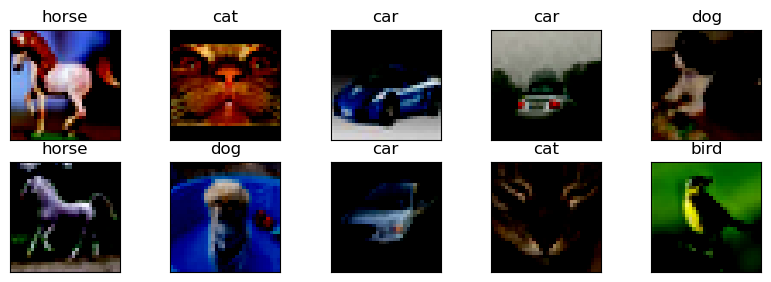

In [9]:
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Pick 30 samples randomly
indices = torch.randperm(len(trainset))[:10]
images = [np.asarray(trainset[i][0]) for i in indices]
labels = [trainset[i][1] for i in indices]

# Visualize the images using matplotlib
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(np.array(images[i]), (1, 2, 0)) )
    ax.set_title(classes[labels[i]])

## Training model

In [10]:
from torchmetrics import Accuracy
from torch.utils.data import random_split
# import lightning. as pl
class LitDeit(pl.LightningModule):
    def __init__(self,teacher_model, student_model, temperature = 1.0, alpha = 0.5):
        super().__init__()
        self.teacher = teacher_model
        # to freeze parameter of teacher model
        for param in self.teacher.parameters():
            param.requires_grad = False
        
        self.student = student_model
        self.temperature = temperature
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.save_hyperparameters()
        self.accuracy = Accuracy(task='multiclass', num_classes=10) 
        self.alpha = alpha
        
           
    def forward(self, inputs):
        student_output = self.student(inputs)
        with torch.no_grad():
            teacher_output = self.teacher(inputs)
        return teacher_output, student_output
    
    def _calulate_loss(self,batch, batch_idx):
        inputs, labels = batch
        teacher_predictions_logits, (student_cls, student_dist_logits) = self(inputs)
        
        student_loss = F.cross_entropy(student_cls, labels)
        
        epsilon = 1e-8  # Small epsilon value to prevent zero probabilities

        teacher_probs = torch.softmax(teacher_predictions_logits / self.temperature, dim=1)
        student_probs = torch.softmax(student_dist_logits / self.temperature, dim=1)

        # Add epsilon to prevent zero probabilities
        teacher_probs = torch.clamp(teacher_probs, epsilon, 1.0)
        student_probs = torch.clamp(student_probs, epsilon, 1.0)
        teacher_log_probs = torch.log(teacher_probs)
        student_log_probs = torch.log(student_probs)

        distillation_loss = F.kl_div(teacher_log_probs, student_log_probs, reduction='batchmean', log_target=True)

#                  = F.kl_div(
#               torch.log_softmax(teacher_probs / self.temperature, axis=1),
#               torch.log_softmax(student_probs / self.temperature, axis=1),  reduction= "batchmean")

          # Compute loss by weighting the two previous losses using the alpha param
        total_loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        # accuracy 
        preds = torch.argmax(student_cls, dim=1)
        acc = self.accuracy(preds, labels)
        return student_loss, distillation_loss, total_loss, acc
    
    def training_step(self, batch, batch_idx):
        student_loss,distillation_loss, total_loss, acc = self._calulate_loss(batch, batch_idx)
             
        self.log('train_distill_loss', distillation_loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_student_loss', student_loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_loss', total_loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        return student_loss 
    
    def validation_step(self, batch, batch_idx):
        student_loss, distillation_loss, total_loss, acc = self._calulate_loss(batch, batch_idx)
               
        self.log('val_loss', total_loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_distill_loss', distillation_loss, on_step=True, on_epoch=True, logger=True)
        self.log('val_student_loss', student_loss, on_step=True, on_epoch=True, logger=True)
        return student_loss
    
    def test_step(self, batch, batch_idx):
        student_loss, distillation_loss, total_loss, acc = self._calulate_loss(batch, batch_idx)
               
        self.log('test_loss', total_loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        self.log('test_distill_loss', distillation_loss, on_step=True, on_epoch=True, logger=True)
        self.log('test_student_loss', student_loss, on_step=True, on_epoch=True, logger=True)
        return student_loss
    
        
#     def predict_step(self, batch, batch_idx, dataloader_idx=0):
#         x, y = batch
#         y_hat = self.model(x)
#         return y_hat

        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.student.parameters(), lr=1e-3)
        return optimizer
    
    def train_dataloader(self):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                                shuffle=True, num_workers=2)
        return trainloader
    
    def val_dataloader(self):
        valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
        
        train_set, val_set = random_split(valset, [int(len(valset)*0.7), len(valset) - int(len(valset)*0.7)])
        valloader = torch.utils.data.DataLoader(val_set, batch_size=32,
                                                    shuffle=False, num_workers=2)
        return valloader 
    
    
    

In [11]:
from lightning import LightningModule
import lightning.pytorch as pl
import math
wandb_logger = WandbLogger(project='deit-lightning', job_type='train')
student_model = DeiT()
model = LitDeit(teacher_model, student_model)

# early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss")
checkpoint_callback = pl.callbacks.ModelCheckpoint()

trainer = pl.Trainer(max_epochs=32,
                     logger=wandb_logger,
                     callbacks=[checkpoint_callback],
                     )
# trainer = pl.Trainer(fast_dev_run=True)
trainer.fit(model)



wandb: Tracking run with wandb version 0.15.4
wandb: Run data is saved locally in ./wandb/run-20230702_021315-4u1hoze5
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run autumn-water-4
wandb: ⭐️ View project at https://wandb.ai/blank0/deit-lightning
wandb: 🚀 View run at https://wandb.ai/blank0/deit-lightning/runs/4u1hoze5
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'teacher_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['teacher_model'])`.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'student_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['student_model'])`.
  rank_zero_warn(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: 

Sanity Checking: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [12]:
trainer.test(model, testloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5774999856948853     │
│  test_distill_loss_epoch  │    2.1424098014831543     │
│         test_loss         │     2.209712266921997     │
│  test_student_loss_epoch  │     2.277013063430786     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.209712266921997,
  'test_acc': 0.5774999856948853,
  'test_distill_loss_epoch': 2.1424098014831543,
  'test_student_loss_epoch': 2.277013063430786}]

In [13]:
wandb.finish()

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:                    epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:                 test_acc ▁
wandb:  test_distill_loss_epoch ▁
wandb:   test_distill_loss_step ▂▂▄▃▇▂▂▄▆▃▄▄▄▆▅▅▁▆▁▄▅▇▅▆▆▆▃▄▅▃▆▆▂▆▂▂▁▁▅█
wandb:                test_loss ▁
wandb:  test_student_loss_epoch ▁
wandb:   test_student_loss_step ▂▃▃▄▃▄▆▆▄▅▆▅▆▄▄▃▂▁▆▄▂▆▆▄▄█▅▅▁▆▂▃▃▂▃▆▂▆▅▄
wandb:          train_acc_epoch ▁▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████████
wandb:           train_acc_step ▁▁▃▂▄▄▄▂▅▄▅▅▅▅▅▆▆▆▆▅▆▇▆▆▆▇▇▇█▇▇▇▇██▆▆█▇▇
wandb: train_distill_loss_epoch █▆▃▁▂▃▃▄▅▅▅▆▆▅▇▇▇▇▆▇▆▆▆▆▆▆▆▆▇▇▇▆
wandb:  train_distill_loss_step █▆▆▃▁▃▃▁▃▆▅▆▆▄▄█▇▇██▇▇▇▆▅▆▇▆▆▇▆▇▆▆▇▇▇▆█▅
wandb:         train_loss_epoch █▆▄▂▂▃▃▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
wandb:          train_loss_step █▅▄▄▁▃▂▂▂▃▃▂▃▂▂▃▃▃▃▃▂▂▃▂▂▂▂▂▁▂▂▂▁▁▁▃▃▂▃▁
wandb: train_student_loss_epoch █▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
wandb:  train_student_loss_step █▅▅▅▃▄▄▅▄▄▄▃▃▃▃▂▃▃▂▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▃▂▂▂▁
wandb:    